In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_knn = pd.read_csv("df_knn_clean.csv")
df_tree = pd.read_csv("df_tree_clean.csv")

X_knn = df_knn.drop(columns=["Cover_Type"])
y_knn = df_knn["Cover_Type"]


X_tree = df_tree.drop(columns=["Cover_Type"])
y_tree = df_tree["Cover_Type"]

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=0
)
d
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.2, stratify=y_tree, random_state=0
)


# Impute M

In [2]:
# Impute missing Slope values for KNN data
slope_median_knn = X_train_knn["Slope"].median()

X_train_knn["Slope"] = X_train_knn["Slope"].fillna(slope_median_knn)
X_test_knn["Slope"]  = X_test_knn["Slope"].fillna(slope_median_knn)


In [3]:
# Impute missing Slope values for Tree data
slope_median_tree = X_train_tree["Slope"].median()

X_train_tree["Slope"] = X_train_tree["Slope"].fillna(slope_median_tree)
X_test_tree["Slope"]  = X_test_tree["Slope"].fillna(slope_median_tree)


# Test results

       Model  balanced_acc      macro_f1   weighted_f1           mcc
         KNN 0.900 ± 0.004 0.909 ± 0.004 0.947 ± 0.001 0.916 ± 0.001
DecisionTree 0.908 ± 0.003 0.867 ± 0.005 0.920 ± 0.001 0.872 ± 0.001


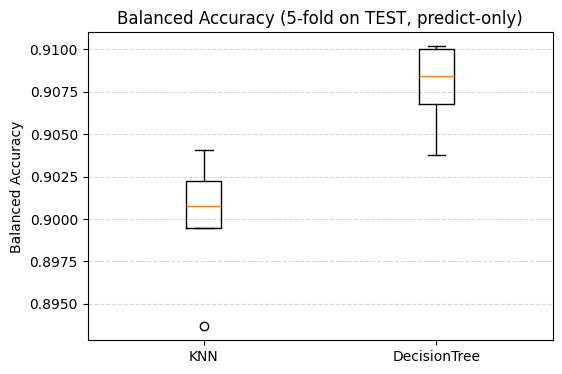

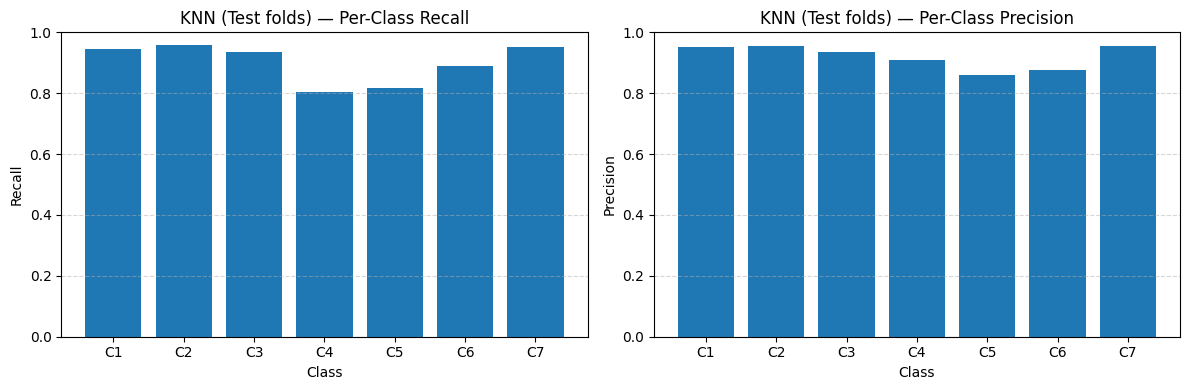

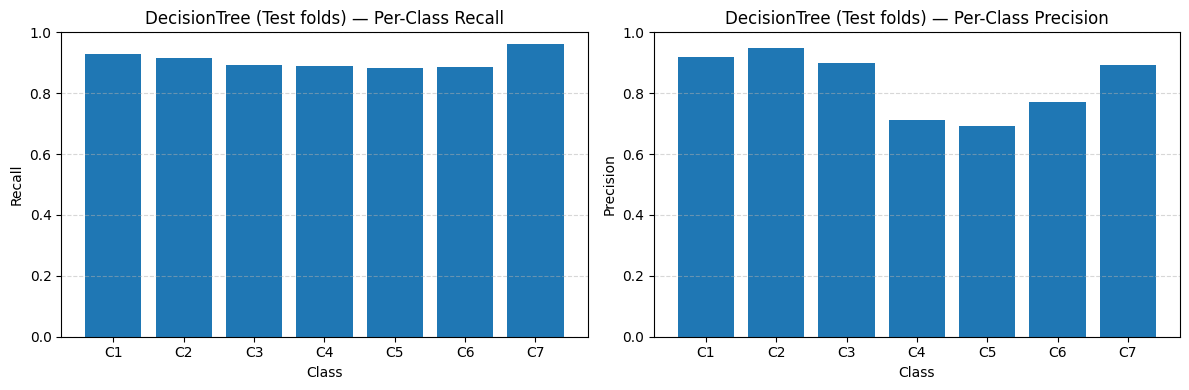

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, matthews_corrcoef, confusion_matrix
)
import joblib

knn_final  = joblib.load("knn_artifacts/knn_best_pipeline.pkl")
tree_final = joblib.load("tree_artifacts/tree_best_model.pkl")


def score_test_in_folds(fitted_model, X_test, y_test, n_splits=5, n_repeats=1, seed=0):
    """
    Split TEST into (repeated) stratified folds; for each fold, predict with the already-fitted model.
    Collect per-fold metrics and aggregate a confusion matrix across all test folds.
    """
    y_test = np.asarray(y_test)
    classes = np.sort(np.unique(y_test))
    per_fold = defaultdict(list)
    agg_cm = np.zeros((len(classes), len(classes)), dtype=np.int64)

    cv = (RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
          if n_repeats > 1 else
          StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed))

    for _, (_, te_idx) in enumerate(cv.split(X_test, y_test), start=1):
        X_te, y_te = X_test.iloc[te_idx], y_test[te_idx]
        y_pred = fitted_model.predict(X_te)

        per_fold["balanced_acc"].append(balanced_accuracy_score(y_te, y_pred))
        per_fold["macro_f1"].append(f1_score(y_te, y_pred, average="macro", zero_division=0))
        per_fold["weighted_f1"].append(f1_score(y_te, y_pred, average="weighted", zero_division=0))
        per_fold["mcc"].append(matthews_corrcoef(y_te, y_pred))

        agg_cm += confusion_matrix(y_te, y_pred, labels=classes)

    return per_fold, agg_cm, classes

def mean_std_str(a):
    a = np.array(a, float)
    return f"{a.mean():.3f} ± {a.std(ddof=1):.003f}"

def plot_rec_prec_from_cm(cm, classes, title_prefix):
    recalls    = np.diag(cm) / (cm.sum(axis=1) + 1e-12)
    precisions = np.diag(cm) / (cm.sum(axis=0) + 1e-12)

    x = np.arange(len(classes)); labels = [f"C{c}" for c in classes]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].bar(x, recalls)
    axes[0].set_title(f"{title_prefix} — Per-Class Recall")
    axes[0].set_xlabel("Class"); axes[0].set_ylabel("Recall")
    axes[0].set_xticks(x); axes[0].set_xticklabels(labels); axes[0].set_ylim(0, 1)
    axes[0].grid(True, axis="y", linestyle="--", alpha=0.5)

    axes[1].bar(x, precisions)
    axes[1].set_title(f"{title_prefix} — Per-Class Precision")
    axes[1].set_xlabel("Class"); axes[1].set_ylabel("Precision")
    axes[1].set_xticks(x); axes[1].set_xticklabels(labels); axes[1].set_ylim(0, 1)
    axes[1].grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout(); plt.show()

N_SPLITS = 5
N_REPEATS = 1 
SEED = 0

knn_pf, knn_cm, knn_classes = score_test_in_folds(
    knn_final, X_test_knn, y_test_knn, n_splits=N_SPLITS, n_repeats=N_REPEATS, seed=SEED
)

tree_pf, tree_cm, tree_classes = score_test_in_folds(
    tree_final, X_test_tree, y_test_tree, n_splits=N_SPLITS, n_repeats=N_REPEATS, seed=SEED
)

summary_df = pd.DataFrame([
    {
        "Model": "KNN",
        "balanced_acc": mean_std_str(knn_pf["balanced_acc"]),
        "macro_f1":      mean_std_str(knn_pf["macro_f1"]),
        "weighted_f1":   mean_std_str(knn_pf["weighted_f1"]),
        "mcc":           mean_std_str(knn_pf["mcc"]),
    },
    {
        "Model": "DecisionTree",
        "balanced_acc": mean_std_str(tree_pf["balanced_acc"]),
        "macro_f1":      mean_std_str(tree_pf["macro_f1"]),
        "weighted_f1":   mean_std_str(tree_pf["weighted_f1"]),
        "mcc":           mean_std_str(tree_pf["mcc"]),
    },
], columns=["Model", "balanced_acc", "macro_f1", "weighted_f1", "mcc"])
print(summary_df.to_string(index=False))


plt.figure(figsize=(6,4))
plt.boxplot([knn_pf["balanced_acc"], tree_pf["balanced_acc"]],
            tick_labels=["KNN","DecisionTree"], showmeans=False)
plt.title(f"Balanced Accuracy ({N_SPLITS}-fold on TEST, predict-only)")
plt.ylabel("Balanced Accuracy")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()

plot_rec_prec_from_cm(knn_cm,  knn_classes,  "KNN (Test folds)")
plot_rec_prec_from_cm(tree_cm, tree_classes, "DecisionTree (Test folds)")


In [23]:
summary_df

,Model,balanced_acc,macro_f1,weighted_f1,mcc
0,KNN,0.900 ± 0.004,0.909 ± 0.004,0.947 ± 0.001,0.916 ± 0.001
1,DecisionTree,0.908 ± 0.003,0.867 ± 0.005,0.920 ± 0.001,0.872 ± 0.001


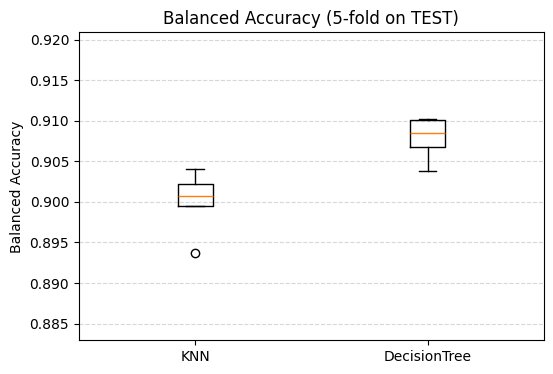

In [24]:

plt.figure(figsize=(6, 4))
plt.boxplot(
    [knn_pf["balanced_acc"], tree_pf["balanced_acc"]],
    tick_labels=["KNN", "DecisionTree"],
    showmeans=False
)

all_vals = knn_pf["balanced_acc"] + tree_pf["balanced_acc"]
y_min, y_max = min(all_vals), max(all_vals)
margin = (y_max - y_min) * 0.65  # 20% padding
plt.ylim(y_min - margin, y_max + margin)

plt.title(f"Balanced Accuracy ({N_SPLITS}-fold on TEST)")
plt.ylabel("Balanced Accuracy")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()


In [21]:
def plot_side_by_side_rec_prec(knn_cm, tree_cm, classes):
    recalls_knn    = np.diag(knn_cm) / (knn_cm.sum(axis=1) + 1e-12)
    precisions_knn = np.diag(knn_cm) / (knn_cm.sum(axis=0) + 1e-12)

    recalls_tree    = np.diag(tree_cm) / (tree_cm.sum(axis=1) + 1e-12)
    precisions_tree = np.diag(tree_cm) / (tree_cm.sum(axis=0) + 1e-12)

    x = np.arange(len(classes))
    labels = [f"C{c}" for c in classes]
    width = 0.4

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Recall ---
    axes[0].bar(x - width/2, recalls_knn, width, label="KNN", color="tab:blue")
    axes[0].bar(x + width/2, recalls_tree, width, label="DecisionTree", color="tab:orange")
    axes[0].set_title("Per-Class Recall")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel("Recall")
    axes[0].grid(True, axis="y", linestyle="--", alpha=0.5)
    axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

    # --- Precision ---
    axes[1].bar(x - width/2, precisions_knn, width, label="KNN", color="tab:blue")
    axes[1].bar(x + width/2, precisions_tree, width, label="DecisionTree", color="tab:orange")
    axes[1].set_title("Per-Class Precision")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel("Precision")
    axes[1].grid(True, axis="y", linestyle="--", alpha=0.5)
    axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

    plt.tight_layout()
    plt.show()


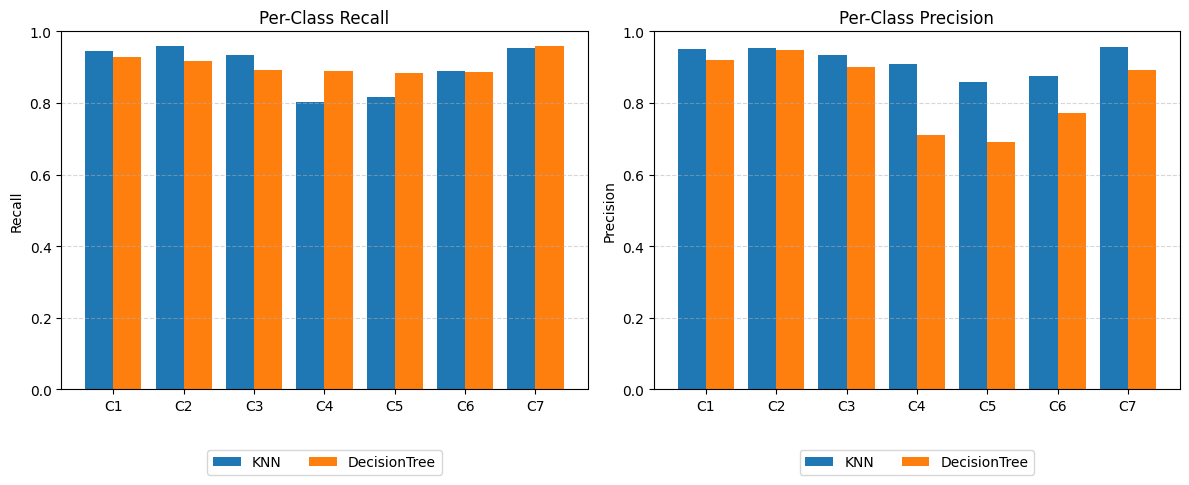

In [22]:

plot_side_by_side_rec_prec(knn_cm, tree_cm, knn_classes)

In [8]:

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef
from scipy.stats import wilcoxon

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
alpha = 0.05
n_splits = 5
n_repeats = 2
random_state = 0

metric_names = ["balanced_acc", "macro_f1", "weighted_f1", "mcc"]

Xk, yk = X_test_knn.copy(), y_test_knn.copy()
Xt, yt = X_test_tree.copy(), y_test_tree.copy()

common_idx = Xk.index.intersection(Xt.index)
Xk = Xk.loc[common_idx]
Xt = Xt.loc[common_idx]
yk = yk.loc[common_idx]
yt = yt.loc[common_idx]

rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

per_fold_metrics = {
    "KNN":          {m: [] for m in metric_names},
    "DecisionTree": {m: [] for m in metric_names},
}

for fold_idx, (_, te_idx) in enumerate(rkf.split(Xk, y_test_common), start=1):
    # Note: te_idx indexes into the *test* matrix (predict-only)
    Xk_te = Xk.iloc[te_idx]
    Xt_te = Xt.iloc[te_idx]
    y_te  = y_test_common[te_idx]

    y_pred_knn  = knn_final.predict(Xk_te)
    y_pred_tree = tree_final.predict(Xt_te)

    for name, y_pred in (("KNN", y_pred_knn), ("DecisionTree", y_pred_tree)):
        per_fold_metrics[name]["balanced_acc"].append(balanced_accuracy_score(y_te, y_pred))
        per_fold_metrics[name]["macro_f1"].append(f1_score(y_te, y_pred, average="macro", zero_division=0))
        per_fold_metrics[name]["weighted_f1"].append(f1_score(y_te, y_pred, average="weighted", zero_division=0))
        per_fold_metrics[name]["mcc"].append(matthews_corrcoef(y_te, y_pred))

def holm_stepdown(pvals, alpha=0.05):
    pvals = np.asarray(pvals, float)
    m = len(pvals)
    order = np.argsort(pvals)
    reject = np.zeros(m, dtype=bool)
    passed = True
    for rank, i in enumerate(order, start=1):
        thr = alpha / (m - rank + 1)
        if np.isfinite(pvals[i]) and pvals[i] <= thr and passed:
            reject[i] = True
        else:
            passed = False
    return reject

rows = []
raw_pvals = []

A, B = "KNN", "DecisionTree"

for m in metric_names:
    a = np.asarray(per_fold_metrics[A][m], float)  # KNN scores across all folds
    b = np.asarray(per_fold_metrics[B][m], float)  # Tree scores across all folds

    mask = np.isfinite(a) & np.isfinite(b)
    a, b = a[mask], b[mask]
    d = a - b

    wins = int(np.sum(d > 0))
    ties = int(np.sum(d == 0))
    losses = int(np.sum(d < 0))
    neff = int(np.sum(d != 0))

    if neff > 0:
        stat, p = wilcoxon(
            a, b,
            zero_method="pratt",      # keep zero differences in ranking
            alternative="two-sided",  # H1: one is different/better
            correction=True,
            method="auto"
        )
    else:
        stat, p = np.nan, np.nan

    raw_pvals.append(p)
    rows.append({
        "Metric": m,
        f"Mean {A}": float(np.mean(a)) if a.size else np.nan,
        f"Mean {B}": float(np.mean(b)) if b.size else np.nan,
        "Median(A-B)": float(np.median(d)) if d.size else np.nan,
        "Wins|Ties|Losses": f"{wins}|{ties}|{losses}",
        "n_eff": neff,
        "Wilcoxon_stat": float(stat) if np.isfinite(stat) else np.nan,
        "p_value_raw": float(p) if np.isfinite(p) else np.nan,
    })

df = pd.DataFrame(rows, columns=[
    "Metric", f"Mean {A}", f"Mean {B}", "Median(A-B)",
    "Wins|Ties|Losses", "n_eff", "Wilcoxon_stat", "p_value_raw"
])

# Holm step-down across the 4 metrics
rej = holm_stepdown(df["p_value_raw"].to_numpy(), alpha=alpha)
df["Decision (Holm, α=0.05)"] = np.where(rej, "reject H0", "fail to reject H0")

# Also show unadjusted decision
df["Decision (raw, α=0.05)"] = np.where(df["p_value_raw"] < alpha, "reject H0", "fail to reject H0")

pd.set_option("display.float_format", lambda v: f"{v:.6f}")
print("\n=== Repeated 5-fold on TEST (×2) — Wilcoxon paired, Holm across metrics ===")
print(df.to_string(index=False))



=== Repeated 5-fold on TEST (×2) — Wilcoxon paired, Holm across metrics ===
      Metric  Mean KNN  Mean DecisionTree  Median(A-B) Wins|Ties|Losses  n_eff  Wilcoxon_stat  p_value_raw Decision (Holm, α=0.05) Decision (raw, α=0.05)
balanced_acc  0.900057           0.907847    -0.006412            1|0|9     10       1.000000     0.003906               reject H0              reject H0
    macro_f1  0.909325           0.866630     0.042494           10|0|0     10       0.000000     0.001953               reject H0              reject H0
 weighted_f1  0.947351           0.919958     0.027483           10|0|0     10       0.000000     0.001953               reject H0              reject H0
         mcc  0.915527           0.871947     0.043701           10|0|0     10       0.000000     0.001953               reject H0              reject H0


In [9]:
df

,Metric,Mean KNN,Mean DecisionTree,Median(A-B),Wins|Ties|Losses,n_eff,Wilcoxon_stat,p_value_raw,"Decision (Holm, α=0.05)","Decision (raw, α=0.05)"
0,balanced_acc,0.900057,0.907847,-0.006412,1|0|9,10,1.000000,0.003906,reject H0,reject H0
1,macro_f1,0.909325,0.866630,0.042494,10|0|0,10,0.000000,0.001953,reject H0,reject H0
2,weighted_f1,0.947351,0.919958,0.027483,10|0|0,10,0.000000,0.001953,reject H0,reject H0
3,mcc,0.915527,0.871947,0.043701,10|0|0,10,0.000000,0.001953,reject H0,reject H0
